<h1>데이터 준비</h1>

In [8]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np

In [122]:
path = 'G:/내 드라이브/Brawlstars_data/일일랭커데이터/'
file_list = os.listdir(path)
print(file_list.pop(-1))
file_list

desktop.ini


['20230309_1159_rankers.csv',
 '20230309_1600_rankers.csv',
 '20230309_1959_rankers.csv',
 '20230310_0141_rankers.csv',
 '20230311_1503_rankers.csv',
 '20230311_1503_users.csv',
 '20230312_0808_users.csv',
 '20230311_2045_users.csv',
 '20230312_1115_users.csv',
 '20230312_0036_users.csv',
 '20230311_2001_users.csv',
 '20230306_2226_rankers.csv',
 '20230307_0024_rankers.csv',
 '20230312_1115_rankers.csv',
 '20230306_2228_rankers.csv',
 '20230312_0036_rankers.csv',
 '20230307_1244_rankers.csv',
 '20230311_2045_rankers.csv',
 '20230311_2001_rankers.csv',
 '20230312_0808_rankers.csv',
 '20230308_1200_rankers.csv',
 '20230307_2037_rankers.csv',
 '20230308_1600_rankers.csv',
 '20230308_2000_rankers.csv',
 '20230310_1222_rankers.csv',
 '20230307_1635_rankers.csv',
 '20230309_0000_rankers.csv',
 '20230310_1222_users.csv',
 '20230310_1600_users.csv',
 '20230310_1600_rankers.csv',
 '20230310_1826_rankers.csv',
 '20230310_1826_users.csv',
 '20230310_2000_rankers.csv',
 '20230310_2000_users.csv',


In [155]:
# ranker 데이터만 추출
ranker_list =[]
for x in file_list: 
    if "rankers" in x:
       ranker_list.append(x)

raw_data = pd.read_csv(path+ranker_list[0])
for i in range(1, len(ranker_list)):
    df = pd.read_csv(path+ranker_list[i])
    raw_data = pd.concat([raw_data, df], axis=0, ignore_index=True)
print(raw_data.columns)
print(raw_data.shape)

Index(['Unnamed: 0', 'battle_time', 'mode', 'map', 'type', 'duration',
       'player_tag', 'player_name', 'player_trophies', 'player_top_brawler',
       'star_player', 'team', 'result', 'rank', 'brawler_id', 'brawler_name',
       'brawler_power', 'brawler_star_power', 'brawler_gadget',
       'brawler_trophies', 'Unnamed: 19', 'Unnamed: 20', 'Unnamed: 21'],
      dtype='object')
(628287, 23)


<h1>데이터 전처리</h1>

In [373]:
## 위험대비 원본 저장
df = raw_data.copy()
df.shape

(628287, 23)

In [374]:
## 불필요한 열 제거
drop_col = [column for column in df.columns if 'Unnamed' in column]
df = df.drop(drop_col, axis=1, inplace=False)
print(df.columns)

Index(['battle_time', 'mode', 'map', 'type', 'duration', 'player_tag',
       'player_name', 'player_trophies', 'player_top_brawler', 'star_player',
       'team', 'result', 'rank', 'brawler_id', 'brawler_name', 'brawler_power',
       'brawler_star_power', 'brawler_gadget', 'brawler_trophies'],
      dtype='object')


<h3>중복 제거</h3>

이슈 : 3대3 배틀의 battle_time은 6개 row를 가지는 게 정상이지만 6개가 넘어가는 현상 발생.

원인분석 : 12시, 4시, 8시로 일일 3~4회 수집을 진행했다. 이 과정에서 발생하는 문제로 예상된다. 예를 들어 a, b 두 플레이어가 한 팀으로 하나의 배틀을 했다. 4시 기준 a 플레이어의 트로피 수가 1,000이고, 8시 기준 a 플레이어의 트로피 수가 1,010이라고 하자. player_trophies값은 데이터를 불러오는 시점의 플레이어정보를 기준으로 하기에, 하나의 배틀 데이터라 하더라도 4시와 8시에 트로피수가 다르므로 결론적으로 데이터프레임에는 다른 데이터로 들어가는 것이다.

해결 : 중복 처리 시 subset=['battle_time', 'mode', 'player_tag', 'brawler_name'] 인수를 넣어준다.

In [375]:
df = df[~df.duplicated(subset=['battle_time', 'mode', 'player_tag', 'brawler_name'])]

<h3>이상치 제거</h3>


<h5>type friendly, tournament 제거</h5>

이슈 : type 이 friendly, tournament인 경우 몇 가지 문제가 발생함.
1. battle_time 수가 맞지 않음
2. brawler_power가 -1
3. brawler_trophies가 -1

해결 : 해당되는 데이터가 많지 않고 제거해도 영향을 미치지 않으므로 제거!


In [376]:
df.shape

(277242, 19)

In [377]:
## type이 friendly, tournament인 경우 드랍
df = df[~df['type'].isin(['friendly', 'tournament'])]
df['type'].unique()

array(['ranked', 'challenge', 'soloRanked', 'teamRanked',
       'championshipChallenge'], dtype=object)

In [378]:
# mode가 duoShowdown 인 경우 제외
df = df[df['mode']!='duoShowdown']

In [379]:
## 각 배틀 팀별 인원
df.groupby(['battle_time', 'mode', 'map', 'type', 'duration', 'team'])[['player_tag']].size().reset_index().iloc[:, -1].value_counts()

3    85036
6       20
Name: 0, dtype: int64

In [380]:
## player_tag 수가 3개가 아닌 경우
df[df.iloc[:, -1]!=3]

,battle_time,mode,map,type,duration,player_tag,player_name,player_trophies,player_top_brawler,star_player,team,result,rank,brawler_id,brawler_name,brawler_power,brawler_star_power,brawler_gadget,brawler_trophies
0,20230309T025215.000Z,brawlBall,Pinhole Punt,ranked,29.0,#U2RGPGLV,PanCake,54300,NITA,0.0,2,victory,NaN,16000012,CROW,11,1,1,942
1,20230309T025215.000Z,brawlBall,Pinhole Punt,ranked,29.0,#2L0G9RVQ9,YOUYOUYTB,60805,SHELLY,0.0,2,victory,NaN,16000047,SQUEAK,11,1,1,906
2,20230309T025215.000Z,brawlBall,Pinhole Punt,ranked,29.0,#22GR90YCV,Lyrexs64,58061,ASH,0.0,2,victory,NaN,16000059,OTIS,11,1,1,905
3,20230309T025215.000Z,brawlBall,Pinhole Punt,ranked,29.0,#GJU2P028,sweetfear,51481,OTIS,1.0,1,victory,NaN,16000029,BEA,11,1,1,1025
4,20230309T025215.000Z,brawlBall,Pinhole Punt,ranked,29.0,#VLQPVPY,Hyra,71910,R-T,0.0,1,victory,NaN,16000002,BULL,11,1,1,1156
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
628102,20230319T141139.000Z,knockout,Belle's Rock,soloRanked,142.0,#RP9C9V8V,hidin,41163,MAX,0.0,2,victory,NaN,16000023,LEON,11,1,1,17
628103,20230319T141139.000Z,knockout,Belle's Rock,soloRanked,142.0,#8L8PUP2UQ,ReyhZor,37590,NITA,0.0,2,victory,NaN,16000037,SPROUT,11,1,1,15
628104,20230319T141139.000Z,knockout,Belle's Rock,soloRanked,142.0,#8V9VJP2P,Korra,41681,PIPER,0.0,1,victory,NaN,16000058,BONNIE,11,1,1,17
628105,20230319T141139.000Z,knockout,Belle's Rock,soloRanked,142.0,#2LV8CQ0YP,FintNiceeee,61784,BEA,1.0,1,victory,NaN,16000015,PIPER,11,1,1,16


In [381]:
# player가 6명이 잡힌 경우 처리

<h5>team 값이 맞지 않는 경우</h5>

이슈 : (듀오쇼다운을 제외한 모드에서) team 값은 1 혹은 2를 가져야 하나 team 값이 0인 경우 발생.

원인분석 : '20230306_2000_rankers.csv' 파일에서 team 값이 0 혹은 1이다.

해결 : '20230306_2000_rankers.csv' 파일 열외.

In [382]:
df['team'] = np.where(df['team']==0, 2, df['team'])

win 열 추가

In [383]:
df['win'] = np.where((df['team']==1) & (df['result']=='victory'), 'win', np.where((df['team']==2) & (df['result']=='defeat'), 'win', 'defeat'))
df.head()

,battle_time,mode,map,type,duration,player_tag,player_name,player_trophies,player_top_brawler,star_player,team,result,rank,brawler_id,brawler_name,brawler_power,brawler_star_power,brawler_gadget,brawler_trophies,win
0,20230309T025215.000Z,brawlBall,Pinhole Punt,ranked,29.0,#U2RGPGLV,PanCake,54300,NITA,0.0,2,victory,NaN,16000012,CROW,11,1,1,942,defeat
1,20230309T025215.000Z,brawlBall,Pinhole Punt,ranked,29.0,#2L0G9RVQ9,YOUYOUYTB,60805,SHELLY,0.0,2,victory,NaN,16000047,SQUEAK,11,1,1,906,defeat
2,20230309T025215.000Z,brawlBall,Pinhole Punt,ranked,29.0,#22GR90YCV,Lyrexs64,58061,ASH,0.0,2,victory,NaN,16000059,OTIS,11,1,1,905,defeat
3,20230309T025215.000Z,brawlBall,Pinhole Punt,ranked,29.0,#GJU2P028,sweetfear,51481,OTIS,1.0,1,victory,NaN,16000029,BEA,11,1,1,1025,win
4,20230309T025215.000Z,brawlBall,Pinhole Punt,ranked,29.0,#VLQPVPY,Hyra,71910,R-T,0.0,1,victory,NaN,16000002,BULL,11,1,1,1156,win


브롤러 클래스 추가

In [384]:
df = df.reset_index(drop=True)

In [385]:
# 브롤러별 클래스
classes = {'Damage Dealer': ['R-T', 'Chester', 'Eve', 'Lola', 'Colette', 'Surge', '8-bit', 'Carl', 'Tara', 'Nita', 'Spike', 'Rico', 'Colt', 'Shelly'],
                    'Tank': ['Buster', 'Meq', 'Ash', 'Jacky', 'Bibi', 'Rosa', 'Frank', 'Darryl', 'El Primo', 'Bull', 'Meg'],
                    'Marksman': ['Mandy', 'Bonnie', 'Janet', 'Belle', 'Nani', 'Bea', 'Piper', 'Brock'],
                    'Artillery': ['Grom', 'Sprout', 'Tick', 'Penny', 'Dynamike', 'Barley'],
                    'Controller': ['Willow', 'Otis', 'Griff', 'Squeak', 'Lou', 'Amber', 'Gale', 'Mr. P', 'Emz', 'Sandy', 'Gene', 'Bo', 'Jessie'],
                    'Assassin': ['Sam', 'Fang', 'Buzz', 'Stu', 'Edgar', 'Leon', 'Crow', 'Mortis'],
                    'Support': ['Gray', 'Gus', 'Ruffs', 'Byron', 'Max', 'Pam', 'Poco']
                    }

# 브롤러명 대문자로 변환
for key in list(classes.keys()):
    classes[key] = [x.upper() for x in classes[key]]

In [386]:
def get_key(val):
    for key, value in classes.items():
         if val in value:
             return key

df['brawler_class'] = [get_key(df['brawler_name'][i]) for i in range(df.shape[0])]

배틀타임 datetime 변환 (pst 기준으로 작업중)

In [388]:
temp = df.copy()

In [389]:
temp.head()

,battle_time,mode,map,type,duration,player_tag,player_name,player_trophies,player_top_brawler,star_player,...,result,rank,brawler_id,brawler_name,brawler_power,brawler_star_power,brawler_gadget,brawler_trophies,win,brawler_class
0,20230309T025215.000Z,brawlBall,Pinhole Punt,ranked,29.0,#U2RGPGLV,PanCake,54300,NITA,0.0,...,victory,NaN,16000012,CROW,11,1,1,942,defeat,Assassin
1,20230309T025215.000Z,brawlBall,Pinhole Punt,ranked,29.0,#2L0G9RVQ9,YOUYOUYTB,60805,SHELLY,0.0,...,victory,NaN,16000047,SQUEAK,11,1,1,906,defeat,Controller
2,20230309T025215.000Z,brawlBall,Pinhole Punt,ranked,29.0,#22GR90YCV,Lyrexs64,58061,ASH,0.0,...,victory,NaN,16000059,OTIS,11,1,1,905,defeat,Controller
3,20230309T025215.000Z,brawlBall,Pinhole Punt,ranked,29.0,#GJU2P028,sweetfear,51481,OTIS,1.0,...,victory,NaN,16000029,BEA,11,1,1,1025,win,Marksman
4,20230309T025215.000Z,brawlBall,Pinhole Punt,ranked,29.0,#VLQPVPY,Hyra,71910,R-T,0.0,...,victory,NaN,16000002,BULL,11,1,1,1156,win,Tank


In [ ]:
temp.info()

In [ ]:
import re
from datetime import datetime
import pytz
from pytz import timezone

t_li = []
for i in range(df.shape[0]):
    t = df['battle_time'][i]
    t_li.append(re.sub(r"[^0-9]", "", t)[:-5])

date_format='%Y%m%d%H%S%Z'
x = t_li[0]

datetime.strptime(x, date_format)

In [350]:
# battle_time 을 datetime으로
import re
from datetime import datetime
import pytz
from pytz import timezone

def get_pst_time():
    date_format='%Y%m%d%H%S%Z'
    date = datetime.now(tz=pytz.utc)
    date = date.astimezone(timezone('America/Los_Angeles'))
    pstDateTime=date.strftime(date_format)
    return pstDateTime

In [ ]:
t_li = []
for i in range(df.shape[0]):
    t = df['battle_time'][i]
    t_li.append(re.sub(r"[^0-9]", "", t)[:-5])
df['battle_time'] = t_li
df['battle_time'] = [datetime.strptime(df['battle_time'][i], '%Y%m%d%H%S') for i in range(df.shape[0])]

In [304]:
df.sort_values(by='battle_time')

,battle_time,mode,map,type,duration,player_tag,player_name,player_trophies,player_top_brawler,star_player,...,result,rank,brawler_id,brawler_name,brawler_power,brawler_star_power,brawler_gadget,brawler_trophies,win,brawler_class
86864,2023-02-27 17:00:40,brawlBall,Beach Ball,ranked,153.0,#QRUQQLV0,CGNukleo,63643,R-T,0.0,...,victory,NaN,16000059,OTIS,11,1,1,994,win,Controller
103012,2023-02-27 17:00:40,heist,Cover Crowd,ranked,144.0,#99YG2U9Y8,Skilominati,51034,POCO,0.0,...,victory,NaN,16000008,NITA,10,1,1,873,defeat,Damage Dealer
103013,2023-02-27 17:00:40,heist,Cover Crowd,ranked,144.0,#898PQUUPG,gast14591,42522,EMZ,0.0,...,victory,NaN,16000026,BIBI,11,1,1,869,defeat,Tank
103014,2023-02-27 17:00:40,heist,Cover Crowd,ranked,21.0,#2R8QLCUG0,Perter,58831,CARL,1.0,...,victory,NaN,16000025,CARL,11,1,1,1127,win,Damage Dealer
103015,2023-02-27 17:00:40,heist,Cover Crowd,ranked,21.0,#LR08G9C8,BCKubaba,61768,SHELLY,0.0,...,victory,NaN,16000000,SHELLY,11,1,1,1127,win,Damage Dealer
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132114,2023-03-12 02:00:44,brawlBall,Beach Ball,ranked,210.0,#R92Y8RPJ,4,44671,TICK,0.0,...,draw,NaN,16000059,OTIS,11,1,1,827,defeat,Controller
132109,2023-03-12 02:00:44,brawlBall,Beach Ball,ranked,45.0,#YC899LQCY,KaiZq,14625,PIPER,0.0,...,victory,NaN,16000015,PIPER,9,1,1,805,defeat,Marksman
132110,2023-03-12 02:00:44,brawlBall,Beach Ball,ranked,45.0,#PLLG8VQUJ,AngelOfDeath,34397,CARL,0.0,...,victory,NaN,16000038,SURGE,11,1,1,816,defeat,Damage Dealer
132111,2023-03-12 02:00:44,brawlBall,Beach Ball,ranked,45.0,#CGYY22LL,Marwann,54077,SURGE,0.0,...,victory,NaN,16000038,SURGE,11,1,1,1034,win,Damage Dealer


In [302]:
df['battle_time'].max()

Timestamp('2023-03-12 02:00:44')

In [299]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 255228 entries, 0 to 255227
Data columns (total 21 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   battle_time         255228 non-null  datetime64[ns]
 1   mode                255228 non-null  object        
 2   map                 255228 non-null  object        
 3   type                255228 non-null  object        
 4   duration            255228 non-null  float64       
 5   player_tag          255228 non-null  object        
 6   player_name         216703 non-null  object        
 7   player_trophies     255228 non-null  int64         
 8   player_top_brawler  255228 non-null  object        
 9   star_player         255228 non-null  float64       
 10  team                255228 non-null  int64         
 11  result              255228 non-null  object        
 12  rank                0 non-null       float64       
 13  brawler_id          255228 no

In [300]:
df.to_csv('G:/내 드라이브/Brawlstars_data/total_230322.csv', encoding='utf-8')

맵별 브롤러 조합

In [395]:
df_win = df[df['win']=='win']

In [450]:
df_combine = df_win.groupby(['battle_time', 'duration', 'map', 'mode'])['brawler_name'].apply(', '.join).reset_index()

In [451]:
df_combine['combination'] = df_combine['brawler_name'].str.split(',')

In [452]:
df_combine['combination'].value_counts()

[EDGAR,  BULL,  SAM]        62
[COLT,  EL PRIMO,  BULL]    56
[BULL,  R-T,  FRANK]        48
[JANET,  OTIS,  R-T]        47
[SAM,  BULL,  EL PRIMO]     44
                            ..
[MANDY,  COLT,  MR. P]       1
[BYRON,  BARLEY,  BROCK]     1
[JACKY,  OTIS,  STU]         1
[EL PRIMO,  CARL,  COLT]     1
[PENNY,  BUZZ,  MAX]         1
Name: combination, Length: 21195, dtype: int64

In [457]:
df_combine

,battle_time,duration,map,mode,brawler_name,combination
0,20230209T154444.000Z,82.0,Undermine,gemGrab,"JACKY, 8-BIT, TARA","[JACKY, 8-BIT, TARA]"
1,20230209T154932.000Z,93.0,Undermine,gemGrab,"JACKY, 8-BIT, TARA","[JACKY, 8-BIT, TARA]"
2,20230227T174057.000Z,37.0,Pinhole Punt,brawlBall,"STU, JANET, MAX","[STU, JANET, MAX]"
3,20230227T174849.000Z,54.0,Sneaky Fields,brawlBall,"CARL, JACKY, NITA","[CARL, JACKY, NITA]"
4,20230227T175645.000Z,120.0,Shooting Star,bounty,"GENE, MAX, EVE","[GENE, MAX, EVE]"
...,...,...,...,...,...,...
42305,20230319T150041.000Z,50.0,Hot Potato,heist,"DYNAMIKE, COLETTE, BULL","[DYNAMIKE, COLETTE, BULL]"
42306,20230319T150301.000Z,86.0,Hot Potato,heist,"BULL, DYNAMIKE, COLETTE","[BULL, DYNAMIKE, COLETTE]"
42307,20230319T150522.000Z,41.0,Hot Potato,heist,"COLETTE, BROCK, BIBI","[COLETTE, BROCK, BIBI]"
42308,20230319T150702.000Z,80.0,Double Swoosh,gemGrab,"SQUEAK, CROW, BO","[SQUEAK, CROW, BO]"


In [445]:
df_combine.to_csv('G:/내 드라이브/Brawlstars_data/df_combine.csv', encoding='utf-8')

In [456]:
comb_count = df_combine.groupby(['map', 'brawler_name'])['brawler_name'].size()
comb_count

map               brawler_name       
Acute Angle       8-BIT, CARL, R-T       11
                  8-BIT, CARL, SAM        4
                  8-BIT, COLT, PAM        1
                  8-BIT, CROW, STU        1
                  8-BIT, NITA, ASH        1
                                         ..
X Marks the Spot  TICK, R-T, FANG         3
                  TICK, R-T, GUS          2
                  TICK, SPIKE, MANDY      1
                  TICK, SPROUT, BROCK     1
                  TICK, SPROUT, PAM       5
Name: brawler_name, Length: 24771, dtype: int64

<h1>게임모드 분석</h1>

<h2>브롤볼</h2>

In [19]:
# brawlBall 모드 데이터 추출
df_brawlball = raw_data[raw_data['mode']=='brawlBall']
df_brawlball_origin = df_brawlball.copy()
# result 값과 연관되는 team=1 만 추출
df_brawlball = df_brawlball[df_brawlball['team']==1]
# result 가 victory인 경우만 추출
df_brawlball_victory = df_brawlball[df_brawlball['result']=='victory']

In [20]:
df_brawlball_victory.describe()

,duration,player_trophies,star_player,team,rank,brawler_id,brawler_power,brawler_star_power,brawler_gadget,brawler_trophies
count,25844.000000,25844.000000,25844.000000,25844.0,0.0,2.584400e+04,25844.000000,25844.000000,25844.0,25844.000000
mean,91.432518,55718.679771,0.334352,1.0,NaN,1.600003e+07,10.718426,0.991952,1.0,884.046935
std,45.516223,11580.183601,0.471773,0.0,NaN,1.957119e+01,1.414979,0.089352,0.0,290.199859
min,19.000000,828.000000,0.000000,1.0,NaN,1.600000e+07,-1.000000,0.000000,1.0,-1.000000
25%,52.000000,52248.000000,0.000000,1.0,NaN,1.600002e+07,11.000000,1.000000,1.0,877.000000
50%,83.000000,59258.000000,0.000000,1.0,NaN,1.600003e+07,11.000000,1.000000,1.0,968.000000
75%,131.000000,62261.000000,1.000000,1.0,NaN,1.600005e+07,11.000000,1.000000,1.0,1034.000000
max,209.000000,75139.000000,1.000000,1.0,NaN,1.600007e+07,11.000000,1.000000,1.0,1274.000000


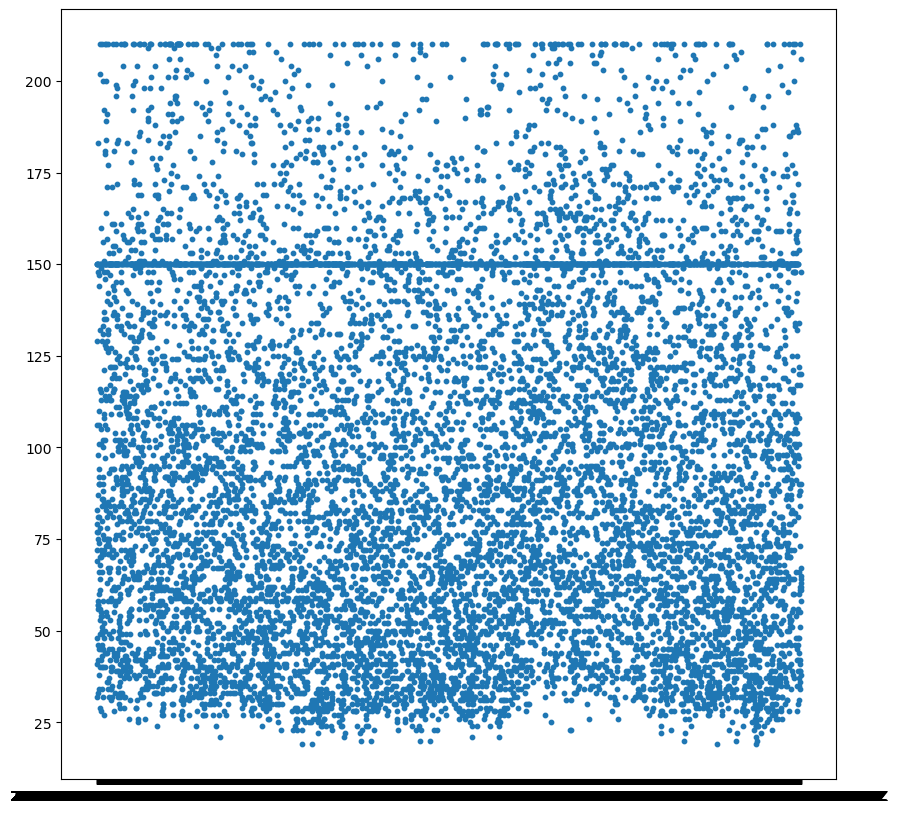

In [21]:
# duration 시각화
temp = df_brawlball[['battle_time', 'duration']]
temp = temp[~temp.duplicated()]

x = temp['battle_time']
y = temp['duration']

plt.figure(figsize=(10, 10))
plt.scatter(x, y, s=10)
plt.show()

<class 'pandas.core.frame.DataFrame'> (20, 2)


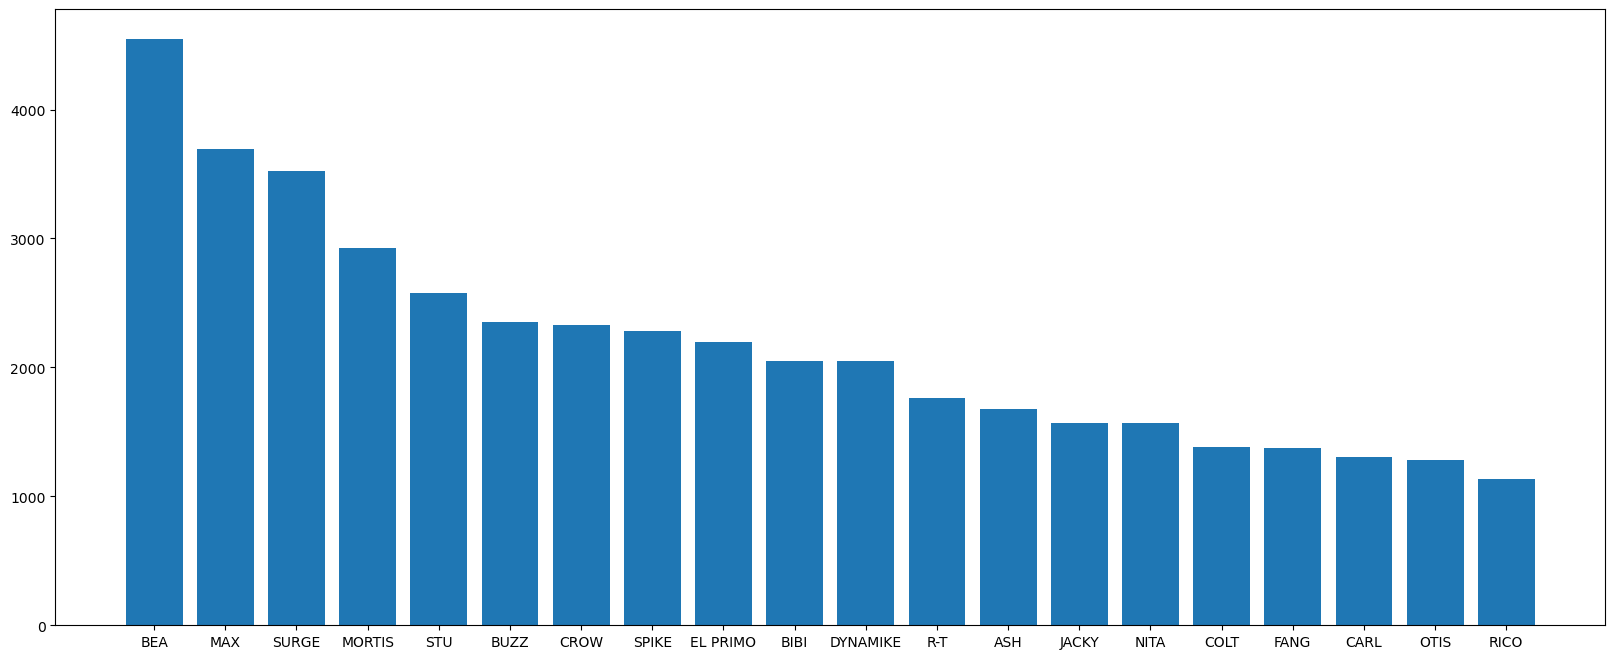

In [22]:
# 브롤러픽 top 20
temp = df_brawlball_origin.groupby(['brawler_name']).count()[['battle_time']].sort_values('battle_time', ascending=False).reset_index()[:20]
print(type(temp), np.shape(temp))

x = temp['brawler_name']
y = temp['battle_time']

plt.figure(figsize=(20, 8))
plt.bar(x, y)
plt.show()

In [23]:
# 브롤러픽 top 5 승패
top = ['BEA', 'MAX', 'SURGE', 'MORTIS', 'CROW']
temp = df_brawlball_origin[df_brawlball_origin['brawler_name'].isin(top)]
temp = temp[temp['team']==1]
print(temp['result'].value_counts())
print()

temp.groupby(['brawler_name', 'result']).count()['battle_time']

victory    5777
defeat     1682
draw         95
Name: result, dtype: int64



brawler_name  result 
BEA           defeat      420
              draw         33
              victory    1774
CROW          defeat      206
              draw         13
              victory     702
MAX           defeat      423
              draw         24
              victory    1641
MORTIS        defeat      271
              draw          8
              victory     495
SURGE         defeat      362
              draw         17
              victory    1165
Name: battle_time, dtype: int64

<class 'pandas.core.frame.DataFrame'> (20, 2)


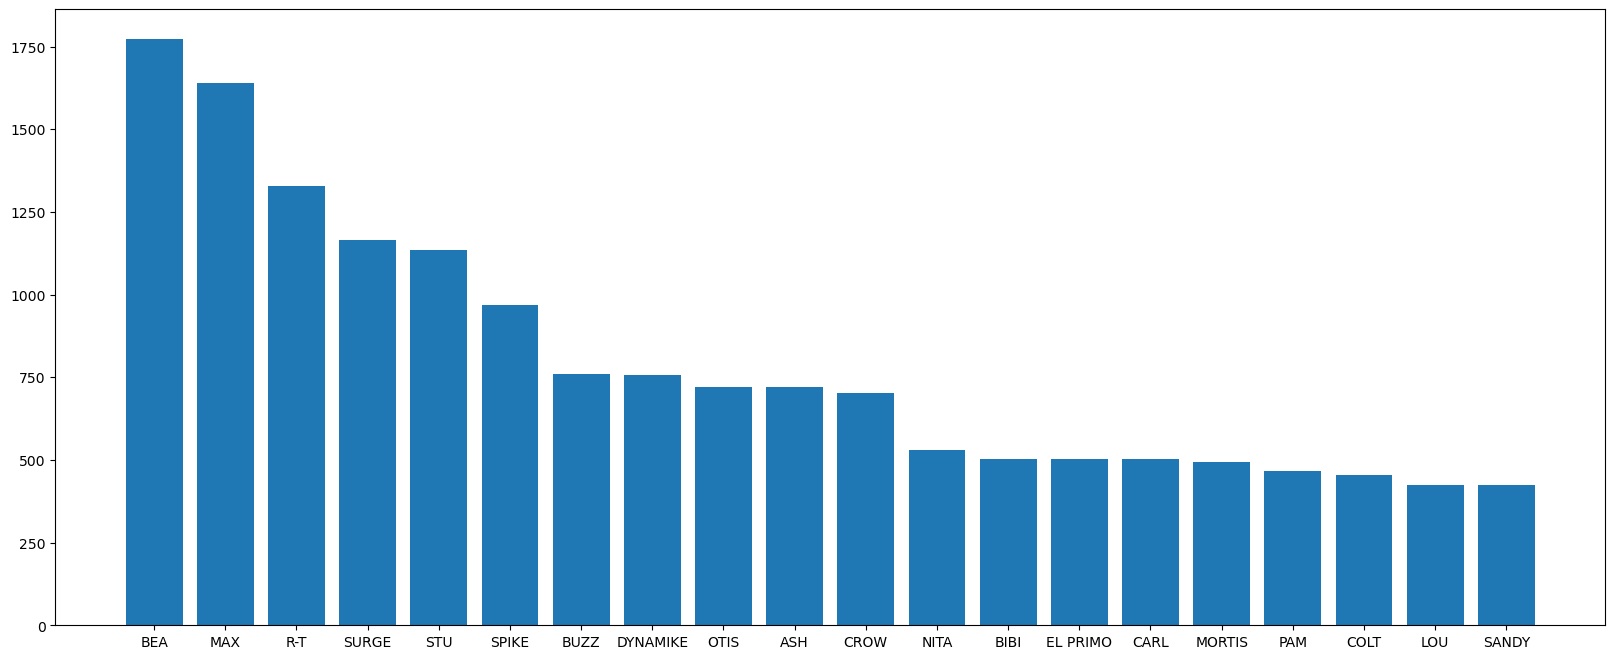

In [24]:
# 승리팀 브롤러픽 top 20
temp = df_brawlball_victory.groupby(['brawler_name']).count()[['battle_time']].sort_values('battle_time', ascending=False).reset_index()[:20]
print(type(temp), np.shape(temp))

x = temp['brawler_name']
y = temp['battle_time']

plt.figure(figsize=(20, 8))
plt.bar(x, y)
plt.show()

<class 'pandas.core.frame.DataFrame'> (20, 2)


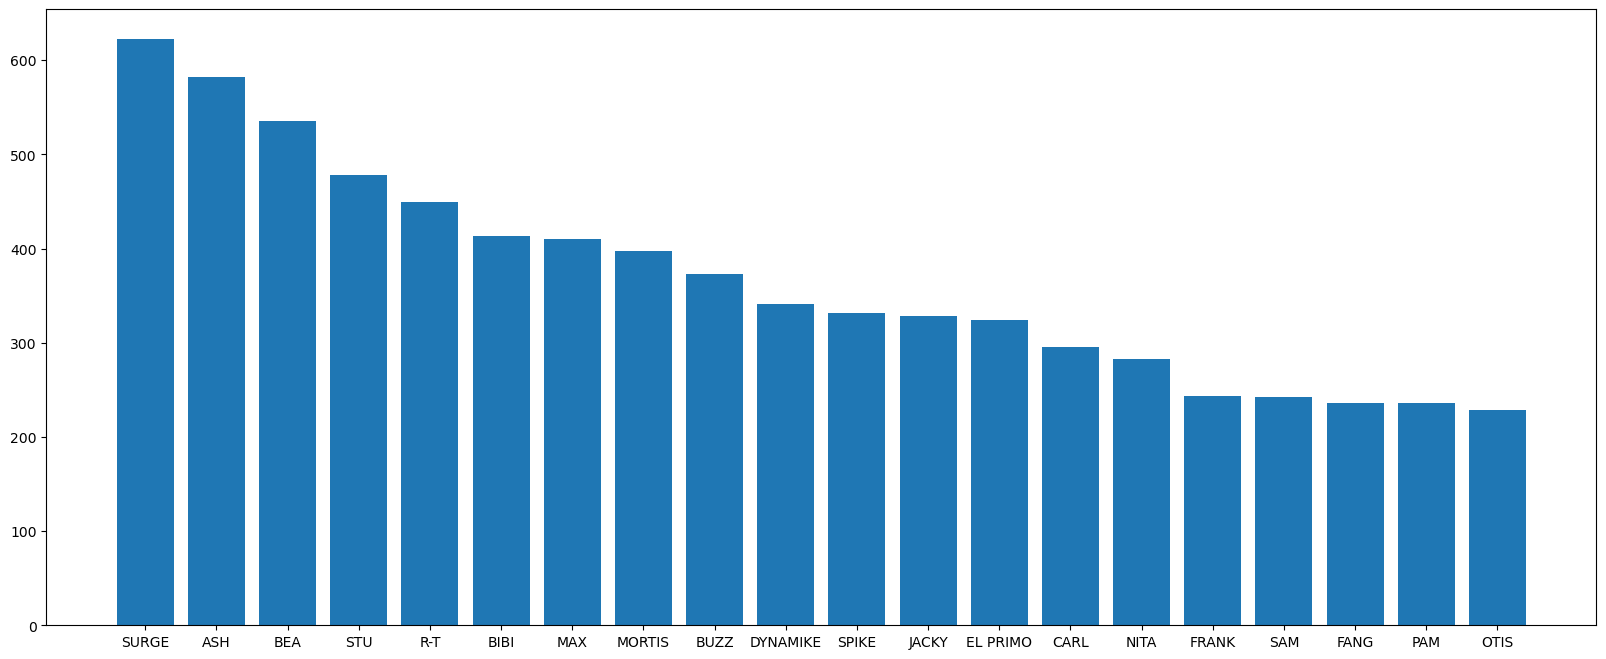

In [25]:
# 스타플레이어 브롤러 top 20
temp = df_brawlball_origin[df_brawlball_origin['star_player']==1]
temp = temp.groupby(['brawler_name']).count()[['battle_time']].sort_values('battle_time', ascending=False).reset_index()[:20]
print(type(temp), np.shape(temp))

x = temp['brawler_name']
y = temp['battle_time']

plt.figure(figsize=(20, 8))
plt.bar(x, y)
plt.show()

<h3>브롤러조합</h3>

<h4>데이터 탐색</h4>

In [5]:
temp = df_brawlball_origin.copy()
temp = temp[['battle_time', 'mode', 'team', 'result', 'brawler_name', 'star_player', 'brawler_power', 'brawler_trophies']]
# temp.head()

## battle_time 값을 하나씩 뽑아서, 그에 맞는 행을 절반으로 나누면 되지 않을까?

a = temp['battle_time'].unique()
temp = temp[temp['battle_time']==a[0]]

# 조합 모음
# temp[:3]['brawler_name'].to_list()
# temp[3:6]['brawler_name'].to_list()

# is_win = 1 if (temp['team']==1) & (temp['result']=='victory') else 0
is_win = 1 if temp['team']==1 and temp['result']=='victory' else 0
# 승리팀 조합
# temp[(temp['team']==1) & (temp['result']=='victory')][:3]['brawler_name'].to_list()

# 패배팀 조합
# temp[(temp['team']==1) & (temp['result']=='defeat')][:3]['brawler_name'].to_list()

temp

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [107]:
temp = df_brawlball_victory.groupby(['battle_time', 'duration'])['brawler_name'].apply(', '.join).reset_index()
temp['brawler_name'] = temp['brawler_name'].str.split(',')
temp['brawler_name'].value_counts()[:20]

[JANET,  OTIS,  R-T]                                                                                                                       36
[GRAY,  MANDY,  R-T]                                                                                                                       33
[SAM,  PAM,  OTIS]                                                                                                                         21
[BEA,  COLT,  SPIKE]                                                                                                                       19
[PAM,  MAX,  R-T]                                                                                                                          19
[MAX,  DARRYL,  STU]                                                                                                                       19
[BO,  ASH,  STU]                                                                                                                           19
[BYRON

In [223]:
# 승리팀 조합
temp = df_brawlball_victory.groupby(['battle_time','mode'])['brawler_name'].apply(', '.join).reset_index()
temp['brawler_name'].value_counts().reset_index(name='count')[:20]

,index,count
0,"JANET, OTIS, R-T",35
1,"GRAY, MANDY, R-T",31
2,"SAM, PAM, OTIS",21
3,"BEA, COLT, SPIKE",19
4,"PAM, MAX, R-T",18
5,"BO, ASH, STU",18
6,"MAX, DARRYL, STU",17
7,"BYRON, ASH, FRANK, BYRON, ASH, FRANK, BYRON, A...",17
8,"SURGE, POCO, R-T, POCO, POCO",16
9,"JESSIE, SPIKE, OTIS, JESSIE, SPIKE, OTIS",16


In [224]:
# 브롤러조합이 3명보다 많은 경우 발견해서 데이터 확인
temp[:20]

,battle_time,mode,brawler_name
0,20230303T164833.000Z,brawlBall,"CARL, BEA, MANDY, FRANK, NITA, SAM, CARL"
1,20230303T165045.000Z,brawlBall,"CARL, BEA, MANDY, CROW, SHELLY, JESSIE, CARL"
2,20230303T165811.000Z,brawlBall,"CARL, BEA, MANDY, RICO, COLT, GALE, CARL"
3,20230303T170106.000Z,brawlBall,"CARL, BEA, MANDY, ROSA, POCO, MORTIS, CARL"
4,20230303T223542.000Z,brawlBall,"SAM, MAX, STU"
5,20230303T223840.000Z,brawlBall,"FRANK, MAX, STU"
6,20230304T092418.000Z,brawlBall,"JACKY, BEA, SURGE, BEA, BEA"
7,20230304T092716.000Z,brawlBall,"BEA, JACKY, SURGE, CARL, SANDY, MORTIS, BEA"
8,20230304T093338.000Z,brawlBall,"CARL, JACKY, BEA, BEA, BEA"
9,20230304T093649.000Z,brawlBall,"CARL, BEA, JACKY, STU, SPIKE, EMZ, BEA"


In [254]:
temp = raw_data[raw_data['battle_time']=='20230303T164833.000Z']
# temp = temp[~temp.duplicated()]
temp
# 중복을 제거해도 6개보다 훨씬 많다.
# team 값이 왜 0이 나오지???
# 하나의 배틀에서 여러명 데이터가 나온다고 해도.....하

,battle_time,mode,map,type,duration,player_tag,player_name,player_trophies,player_top_brawler,star_player,team,result,rank,brawler_id,brawler_name,brawler_power,brawler_star_power,brawler_gadget,brawler_trophies,Unnamed: 0
123209,20230303T164833.000Z,brawlBall,Circular Motion,ranked,154.0,#VLRGLLVR,sofi,17108,BEA,0,1,victory,NaN,16000025,CARL,10,1,1,543,NaN
123210,20230303T164833.000Z,brawlBall,Circular Motion,ranked,154.0,#YRVYYR2U,NaN,32483,BO,0,1,victory,NaN,16000029,BEA,10,1,1,524,NaN
123211,20230303T164833.000Z,brawlBall,Circular Motion,ranked,154.0,#2GLRPQQ00,piscismoke,60724,COLETTE,1,1,victory,NaN,16000065,MANDY,11,1,1,520,NaN
123212,20230303T164833.000Z,brawlBall,Circular Motion,ranked,154.0,#JLL9U99P,YBJ,19259,SPIKE,0,2,victory,NaN,16000020,FRANK,7,0,1,523,NaN
123213,20230303T164833.000Z,brawlBall,Circular Motion,ranked,154.0,#YV2RYJC0,BeratAliYT,24670,BIBI,0,2,victory,NaN,16000008,NITA,9,1,1,504,NaN
123214,20230303T164833.000Z,brawlBall,Circular Motion,ranked,154.0,#8PCGPGU2C,MZdarietto9,23491,BUSTER,0,2,victory,NaN,16000060,SAM,8,0,1,548,NaN


In [248]:
# 각 배틀마다 team마다 수가 어떤지
temp = raw_data.groupby(['battle_time', 'mode', 'map', 'type', 'duration', 'team'])[['player_tag']].size().reset_index()
temp

,battle_time,mode,map,type,duration,team,0
0,20230302T182732.000Z,knockout,Goldarm Gulch,ranked,56.0,0,3
1,20230302T182732.000Z,knockout,Goldarm Gulch,ranked,56.0,1,4
2,20230302T182732.000Z,knockout,Goldarm Gulch,ranked,56.0,2,7
3,20230302T183047.000Z,knockout,Goldarm Gulch,ranked,81.0,0,3
4,20230302T183047.000Z,knockout,Goldarm Gulch,ranked,81.0,1,6
...,...,...,...,...,...,...,...
45205,20230312T024133.000Z,brawlBall,Iron Corridor,ranked,103.0,2,3
45206,20230312T024228.000Z,brawlBall,Iron Corridor,ranked,150.0,1,3
45207,20230312T024228.000Z,brawlBall,Iron Corridor,ranked,150.0,2,3
45208,20230312T024405.000Z,brawlBall,Iron Corridor,ranked,60.0,1,3


In [ ]:
# team 값으로 0이 있는 battle_time만 추출
temp_li = temp[temp['team']==0]['battle_time'].to_list()
# csv 파일로 저장
temp[temp['battle_time'].isin(temp_li)].to_csv('C:/Users/yenny/Desktop/team0.csv', encoding='utf-8')

In [218]:
# 팀
raw_data['team'].unique()

array([1, 2, 4, 5, 6, 3, 0], dtype=int64)

In [132]:
raw_data[raw_data['type']=='soloRanked']['battle_time'].value_counts()

20230306T115900.000Z    65
20230306T135416.000Z    62
20230307T220600.000Z    57
20230308T110430.000Z    54
20230308T001811.000Z    52
                        ..
20230306T145201.000Z     6
20230306T150340.000Z     6
20230306T151134.000Z     6
20230306T152328.000Z     6
20230309T083210.000Z     6
Name: battle_time, Length: 2753, dtype: int64

<h3>결측치 제거</h3>

type 이 friendly, tournament인 경우 몇 가지 문제가 발생함.
1. battle_time 수가 맞지 않음
2. brawler_power가 -1
3. brawler_trophies가 -1

따라서 제외!

In [ ]:
# type이 friendly, tournament인 경우
# index_list = raw_data[raw_data['type'].isin(['friendly', 'tournament'])].index # 다른 type에서도 신뢰할만하지 못한 결과로 보임. 따라서 ranked만 남긴다.

## type이 ranked가 아닌 경우 제외
index_list = raw_data[~raw_data['type'].isin(['ranked'])].index
raw_data = raw_data.drop(index_list, axis=0)
raw_data.shape

<h2>하이스트 모드</h2>

In [14]:
# heist 모드 데이터 추출
df_heist = df[df['mode']=='heist']
df_heist_origin = df_heist.copy()
# result 값을 가지는 team=1 만 추출
df_heist = df_heist[df_heist['team']==1]
# result 가 victory인 경우만 추출
df_heist = df_heist[df_heist['result']=='victory']

In [15]:
df_heist.describe()

,duration,player_trophies,star_player,team,rank,brawler_id,brawler_power,brawler_star_power,brawler_gadget,brawler_trophies
count,894.000000,894.000000,894.000000,894.0,0.0,8.940000e+02,894.000000,894.000000,894.0,894.000000
mean,68.724832,55541.219239,0.332215,1.0,NaN,1.600002e+07,10.497763,0.997763,1.0,870.866890
std,35.738949,11236.014584,0.471271,0.0,NaN,1.935303e+01,2.091816,0.047272,0.0,367.530241
min,20.000000,6540.000000,0.000000,1.0,NaN,1.600000e+07,-1.000000,0.000000,1.0,-1.000000
25%,41.000000,55139.000000,0.000000,1.0,NaN,1.600001e+07,11.000000,1.000000,1.0,910.250000
50%,61.500000,59655.500000,0.000000,1.0,NaN,1.600003e+07,11.000000,1.000000,1.0,989.000000
75%,86.000000,62063.500000,1.000000,1.0,NaN,1.600004e+07,11.000000,1.000000,1.0,1093.000000
max,150.000000,67781.000000,1.000000,1.0,NaN,1.600007e+07,11.000000,1.000000,1.0,1174.000000


In [21]:
df_heist[df_heist['brawler_power']<0][['brawler_name', 'brawler_power']]

,brawler_name,brawler_power
603,PIPER,-1
604,BONNIE,-1
605,8-BIT,-1
5705,DARRYL,-1
5706,CARL,-1
5707,LOLA,-1
5741,GALE,-1
5742,BONNIE,-1
5743,LOLA,-1
7111,MAX,-1


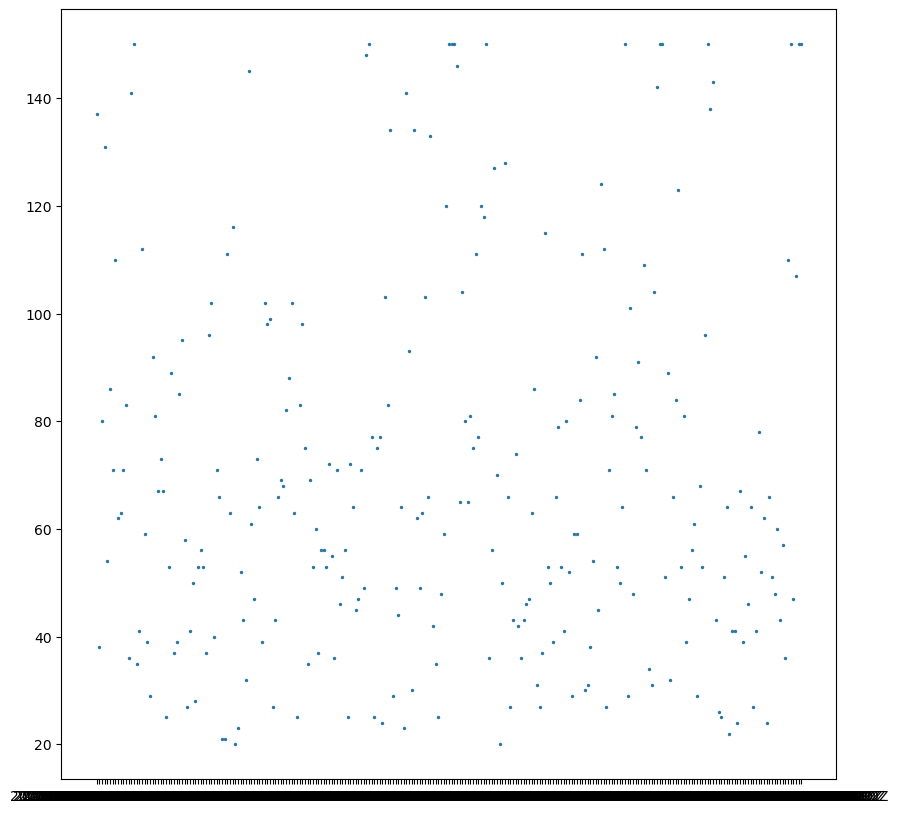

In [17]:
temp = df_heist[['battle_time', 'duration']]
temp = temp[~temp.duplicated()]

x = temp['battle_time']
y = temp['duration']

plt.figure(figsize=(10, 10))
plt.scatter(x, y, s=2)
plt.show()

In [18]:
# 브롤러픽 top 20
df_heist_origin['brawler_name'].value_counts()[:20]

BIBI        273
BULL        240
COLT        176
EDGAR       167
DYNAMIKE    152
EL PRIMO    149
NITA        127
DARRYL      117
BUZZ         99
SAM          93
MAX          69
COLETTE      60
EVE          40
SURGE        38
CARL         38
EMZ          36
JESSIE       36
BROCK        35
BARLEY       33
PIPER        32
Name: brawler_name, dtype: int64

In [44]:
# 브롤러픽 top 5 승패
top = ['BIBI', 'BULL', 'COLT', 'EDGAR', 'DYNAMIKE']
temp = df_heist_origin[df_heist_origin['brawler_name'].isin(top)]
temp = temp[temp['team']==1]
print(temp['result'].value_counts())
print()

temp.groupby(['brawler_name', 'result']).count()['battle_time']

victory    469
defeat     103
Name: result, dtype: int64



brawler_name  result 
BIBI          defeat      21
              victory    122
BULL          defeat      32
              victory    139
COLT          defeat      21
              victory     65
DYNAMIKE      defeat      11
              victory     61
EDGAR         defeat      18
              victory     82
Name: battle_time, dtype: int64

In [19]:
# 승리팀 브롤러픽 top 20
df_heist['brawler_name'].value_counts()[:20]

BULL        139
BIBI        122
EDGAR        82
COLT         65
DYNAMIKE     61
EL PRIMO     54
SAM          51
DARRYL       51
MAX          45
BUZZ         39
EVE          26
COLETTE      26
EMZ          16
NITA         16
BARLEY       11
JESSIE        7
SURGE         7
BELLE         6
RICO          6
PENNY         6
Name: brawler_name, dtype: int64

In [40]:
# 브롤러픽 top 5 승패
top = ['BIBI', 'BULL', 'COLT', 'EDGAR', 'DYNAMIKE']
temp = df_heist[df_heist['brawler_name'].isin(top)]
temp = temp[temp['team']==1]
temp['result'].value_counts()

victory    469
Name: result, dtype: int64

In [20]:
# 스타플레이어 브롤러 top 20
df_heist[df_heist['star_player']==1]['brawler_name'].value_counts()[:20]

BIBI        55
BULL        52
COLT        35
EDGAR       27
DYNAMIKE    22
EL PRIMO    21
SAM         20
DARRYL      16
BUZZ        11
COLETTE      8
BARLEY       3
EVE          3
MAX          3
NITA         3
BONNIE       2
RICO         2
NANI         2
CARL         2
EMZ          2
8-BIT        1
Name: brawler_name, dtype: int64

<h1>맵 분석</h1>

In [103]:
df.head()

,battle_time,mode,map,type,duration,player_tag,player_name,player_trophies,player_top_brawler,star_player,team,result,rank,brawler_id,brawler_name,brawler_power,brawler_star_power,brawler_gadget,brawler_trophies
0,20230307T204215.000Z,brawlBall,Beach Ball,ranked,129.0,#88V9YJV8,BomboRasta,57384,SURGE,0,1,victory,NaN,16000038,SURGE,11,1,1,1075
1,20230307T204215.000Z,brawlBall,Beach Ball,ranked,129.0,#VLQPVPY,Hyra,70443,R-T,1,1,victory,NaN,16000056,EVE,11,1,1,1090
2,20230307T204215.000Z,brawlBall,Beach Ball,ranked,129.0,#8LQ9JR82,CodeEqwaak,69079,BULL,0,1,victory,NaN,16000060,SAM,11,1,1,1079
3,20230307T204215.000Z,brawlBall,Beach Ball,ranked,129.0,#2PUQRVJL2,Militony,46849,SPIKE,0,2,victory,NaN,16000005,SPIKE,11,1,1,845
4,20230307T204215.000Z,brawlBall,Beach Ball,ranked,129.0,#2GJ8YQGYG,Favide51,47319,JACKY,0,2,victory,NaN,16000034,JACKY,11,1,1,836


In [106]:
df[df['team']==1]

,battle_time,mode,map,type,duration,player_tag,player_name,player_trophies,player_top_brawler,star_player,team,result,rank,brawler_id,brawler_name,brawler_power,brawler_star_power,brawler_gadget,brawler_trophies
0,20230307T204215.000Z,brawlBall,Beach Ball,ranked,129.0,#88V9YJV8,BomboRasta,57384,SURGE,0,1,victory,NaN,16000038,SURGE,11,1,1,1075
1,20230307T204215.000Z,brawlBall,Beach Ball,ranked,129.0,#VLQPVPY,Hyra,70443,R-T,1,1,victory,NaN,16000056,EVE,11,1,1,1090
2,20230307T204215.000Z,brawlBall,Beach Ball,ranked,129.0,#8LQ9JR82,CodeEqwaak,69079,BULL,0,1,victory,NaN,16000060,SAM,11,1,1,1079
9,20230307T203827.000Z,brawlBall,Beach Ball,ranked,32.0,#88V9YJV8,BomboRasta,57384,SURGE,0,1,victory,NaN,16000038,SURGE,11,1,1,1070
10,20230307T203827.000Z,brawlBall,Beach Ball,ranked,32.0,#VLQPVPY,Hyra,70443,R-T,1,1,victory,NaN,16000056,EVE,11,1,1,1085
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15362,20230307T075503.000Z,knockout,Flaring Phoenix,ranked,75.0,#2G82CGU,Zee,60500,MR. P,0,1,victory,NaN,16000031,MR. P,11,1,1,934
15363,20230307T075503.000Z,knockout,Flaring Phoenix,ranked,75.0,#9UCRLVGC8,nat,58531,JACKY,0,1,victory,NaN,16000015,PIPER,11,1,1,1010
15364,20230307T075206.000Z,knockout,Flaring Phoenix,ranked,178.0,#9YYUPGJ2V,Nerf,60650,MANDY,1,1,victory,NaN,16000065,MANDY,11,1,1,1010
15365,20230307T075206.000Z,knockout,Flaring Phoenix,ranked,178.0,#2G82CGU,Zee,60500,MR. P,0,1,victory,NaN,16000031,MR. P,11,1,1,928


<h2>듀오쇼다운</h2>

In [22]:
df.shape

(15370, 19)

In [15]:
df.groupby('battle_time').size().sort_values(ascending=True)

battle_time
20230307T031706.000Z     1
20230307T201315.000Z     1
20230307T053337.000Z     2
20230306T162821.000Z     2
20230307T040734.000Z     2
                        ..
20230307T191713.000Z    18
20230307T190530.000Z    18
20230307T192614.000Z    18
20230307T065039.000Z    18
20230307T202949.000Z    18
Length: 2286, dtype: int64

In [13]:
df[df['battle_time']=='20230307T031706.000Z']

,battle_time,mode,map,type,duration,player_tag,player_name,player_trophies,player_top_brawler,star_player,team,result,rank,brawler_id,brawler_name,brawler_power,brawler_star_power,brawler_gadget,brawler_trophies
12046,20230307T031706.000Z,brawlBall,Beach Ball,friendly,34.0,#28YUL8GYC,Shady,61186,NITA,1,1,victory,NaN,16000058,BONNIE,-1,1,1,-1


In [14]:
df[df['battle_time']=='20230307T205654.000Z']

,battle_time,mode,map,type,duration,player_tag,player_name,player_trophies,player_top_brawler,star_player,team,result,rank,brawler_id,brawler_name,brawler_power,brawler_star_power,brawler_gadget,brawler_trophies
14280,20230307T205654.000Z,brawlBall,Backyard Bowl,friendly,88.0,#LG8PCJG8,PitchDTex,60776,GRAY,1,1,victory,NaN,16000059,OTIS,-1,1,1,-1
14281,20230307T205654.000Z,brawlBall,Backyard Bowl,friendly,88.0,#98CPR2PG0,PitchDLxnny,54435,PIPER,0,2,victory,NaN,16000032,MAX,-1,1,1,-1


In [25]:
df[df['brawler_power']==-1]['type'].value_counts()

friendly      560
tournament    150
Name: type, dtype: int64

In [21]:
df[df['brawler_trophies']==-1]

,battle_time,mode,map,type,duration,player_tag,player_name,player_trophies,player_top_brawler,star_player,team,result,rank,brawler_id,brawler_name,brawler_power,brawler_star_power,brawler_gadget,brawler_trophies
450,20230307T175337.000Z,brawlBall,Pinhole Punt,friendly,29.0,#9PQQ8GQQ,Filippo,53687,SURGE,1,2,defeat,NaN,16000025,CARL,-1,1,1,-1
451,20230307T175337.000Z,brawlBall,Pinhole Punt,friendly,29.0,#89Q0G0QQ,Jaime,54804,PIPER,0,2,defeat,NaN,16000032,MAX,-1,1,1,-1
452,20230307T175337.000Z,brawlBall,Pinhole Punt,friendly,29.0,#8RUV8QCJ,Lars,57719,ASH,0,2,defeat,NaN,16000058,BONNIE,-1,1,1,-1
453,20230307T175337.000Z,brawlBall,Pinhole Punt,friendly,29.0,#VGPLRCVQ,Buzkoa,67845,PIPER,0,1,defeat,NaN,16000019,PENNY,-1,1,1,-1
454,20230307T175337.000Z,brawlBall,Pinhole Punt,friendly,29.0,#L08QR0J8U,CoSlX,37383,BULL,0,1,defeat,NaN,16000030,EMZ,-1,1,1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14933,20230307T181837.000Z,gemGrab,Hard Rock Mine,friendly,107.0,#9P022PUY,IMPimk,49592,JANET,0,2,defeat,NaN,16000061,GUS,-1,1,1,-1
15078,20230307T191001.000Z,knockout,Belle's Rock,friendly,109.0,#YLV8CL0R,ExQAsTa,60674,EMZ,1,1,victory,NaN,16000064,GRAY,-1,1,1,-1
15079,20230307T191001.000Z,knockout,Belle's Rock,friendly,109.0,#8VUJQJ08R,GOmega,52273,BULL,0,2,victory,NaN,16000011,MORTIS,-1,1,1,-1
15080,20230307T190738.000Z,knockout,Belle's Rock,friendly,110.0,#YLV8CL0R,ExQAsTa,60674,EMZ,0,1,defeat,NaN,16000065,MANDY,-1,1,1,-1


In [63]:
temp = df[df['brawler_power']==-1].groupby('battle_time').size()
temp_li = temp[temp<6].reset_index()['battle_time'].to_list()
df[df['battle_time'].isin(temp_li)]['type'].value_counts()

friendly    109
ranked        6
Name: type, dtype: int64

In [101]:
# 승리팀 조합
temp = df_brawlball[~df_brawlball.duplicated()]
temp = temp.groupby(['battle_time', 'duration'])['brawler_name'].apply(', '.join).reset_index()
temp['brawler_name'].value_counts()
# temp

BEA, FRANK, MORTIS     16
SPIKE, MR. P, MANDY    14
STU, SPIKE, EMZ        13
MAX, SURGE, R-T        12
SPIKE, OTIS, COLT      10
                       ..
8-BIT, GRAY, NITA       1
SPIKE, EMZ, STU         1
SURGE, MAX, R-T         1
MORTIS, BEA, FRANK      1
SPIKE, BEA, ASH         1
Name: brawler_name, Length: 350, dtype: int64